# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## [Final Project] Social Media Toxicity Shield: Milestone 5


**Harvard University**<br/>
**Spring 2025**<br/>
**Team**: Amar Boparai, Andrew Lobo, Conrad Kaminski, Xiaoxuan Zhang, Xuanthe Nguyen<br/>
**Canvas Project Group**: 31

<hr style="height:2pt">

In [ ]:
# Library Imports
import os
import pickle
import re
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from collections import Counter
import textwrap

from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall, MeanIoU, AUC, BinaryAccuracy
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.cluster import KMeans


from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import evaluate
import torch

# Huggingface
from transformers import EarlyStoppingCallback

# For training Electra
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_from_disk

# For training FastText
from torch.utils.data import DataLoader, Datasets
from datasets import Dataset

import torch.optim as optim

import hashlib
import torch, torch.nn as nn, torch.nn.functional as F



In [ ]:
# Issues with the below imports on my local machine—will likely resort to JupyterHub
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDebertaV2ForSequenceClassification
from transformers import TFBertPreTrainedModel, TFBertMainLayer

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"

### Libraries Used

Throughout this project, we used several crucial libraries.

For example, the *Hugging Face Transformers* library allowed us to implement models like DistilBERT. We also used *TensorFlow* and *Keras* to build, train, and evaluate deep learning models. We also made use of *Scikit-learn* for pre-processing, *Matplotlib* and *Seaborn* for visualizations, and several other packages imported above.

<a id="contents"></a>
# Table of Contents
1. [**Problem Statement Refinement and Introduction**](#intro)
2. [**Comprehensive EDA Review**](#eda)
    - [**Key EDA Findings**](#find)
    - [**Initial Preprocessing**](#preprocess1)
    - [**Additional Preprocessing**](#preprocess2)
3. [**Modeling**](#model)
    - [**Baseline Model Choice**](#choice)
    - [**Training Process**](#train)
    - [**Initial Results**](#result)
4. [**Results Interpretation & Analysis**](#interp)
    - [**Analysis of Baseline Model Performance**](#analysis)
    - [**Proposed Improvements**](#improve)
5. [**Final Model Pipeline**](#final)
    - [**Assumptions, Parameter Choices, and Preliminary Tuning Considerations**](#assum)

<a id="intro"></a>

# 1. Problem Statement and Introduction

[Return to contents](#contents)

## Introduction
Online platforms vary widely in functionality and purpose, yet they all face a common problem: toxic content. Harmful posts can negatively impact users’ well-being—contributing to anxiety, depression, and other mental-health issues—and rely heavily on human moderators to keep forums safe. Although many platforms censor slurs or profanity, toxicity often goes beyond “bad words.” With today’s advanced tools, we have an opportunity to monitor—and mitigate—toxicity more effectively.

As a reminder, we’re using the Jigsaw Unintended Bias in Toxicity Classification dataset from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification), which contains approximately 1.9 million comments labeled for various forms of toxicity.

## Problem Statement
- **Primary goal:** How can we reliably predict the toxicity of online comments?  
- **Secondary goals:** Which features contribute most to toxicity, and how can we assess our model’s fairness across different identity attributes?  
  In particular, many comments containing identity markers are labeled toxic more often than not—so we need to ensure our model can accurately detect toxicity regardless of such markers.

  
## Data Description
We are using the Jigsaw Unintended Bias in Toxicity Classification dataset from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification), which contains ~1.9 million online comments labeled for various forms of toxicity. Our final dataset includes comment_text as input and seven binary toxicity labels as outputs (toxic, insult, threat). The data is highly imbalanced, with most toxicity categories appearing in less than 10% of the samples.

The data file is an csv file which we used Pandas to parse and do future processing in the sections below.

<a id="eda"></a>

# 2. EDA & Data Processing
[Return to contents](#contents)

<a id="find"></a>

## Primary EDA Findings

[Return to contents](#contents)

- The most frequent words in toxic comments often have political connotations or express societal opinions (e.g., “people,” “state”). 
    - This doesn’t impact our feature engineering—just an interesting observation.  
- There is a significant class imbalance in the `toxic` class, as well as in most other variables (except `insult`):  
  - We combined the `severe_toxic` and `toxic` labels, since both capture the outcome we care about—whether a comment is toxic.  
  - To keep our training corpus robust, we will upsample toxic comments
  - When we have more time, we would also leverage a GPT-based generator to introduce more variety into the positive class.  
- The `insult` and `toxic` labels are highly correlated (0.75), while `toxic` shows only weak correlations with other predictors—another obvious but noteworthy point: toxicity often manifests as insults.  
- Most comments are under 250 characters, with frequency decaying exponentially until around 1,000 characters, where there’s a slight uptick (see image below). 
    - This pattern likely won’t affect feature extraction, but it may guide our choice of maximum sequence length for the tokenizer.

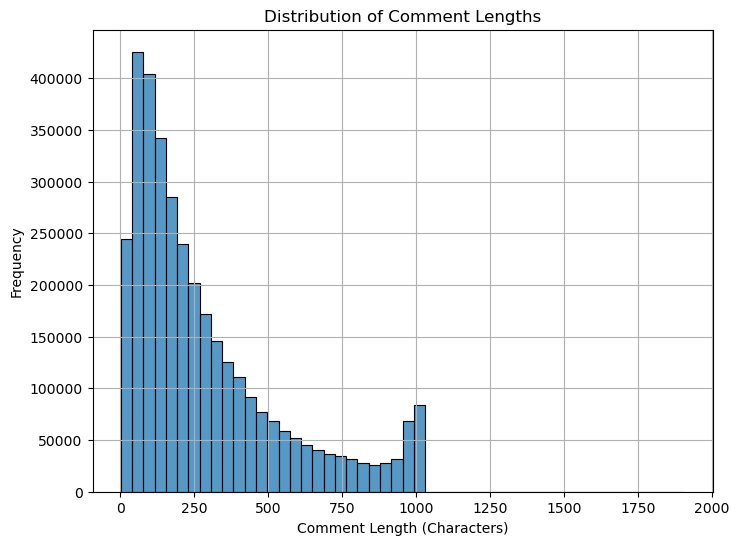
<p align="left"><strong>Figure 1.1: Distribution of Comment Lengths</strong></p>

---


The histogram above shows a right-skewed distribution. Most comments are relatively short (under 250 characters). After 1000 characters, there is almost a complete drop off.

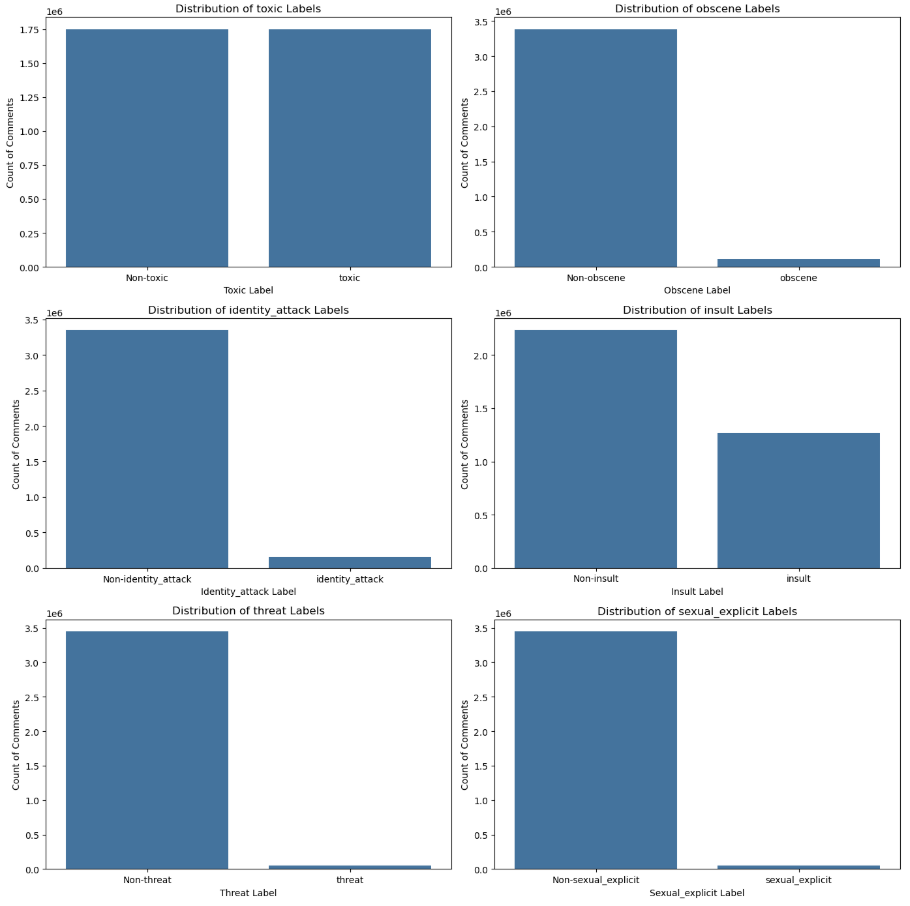

<p align="left"><strong>Figure 1.2: Distribution of Labels</strong></p>

The labels, with the exception of `toxic`, are heavily imbalanced. `insult` also seems to be relatively balanced. We will not be balancing the other predictors other toxicity labels because our predictive model is solely focused on predicting the toxic label, and the other toxicity labels are being used mainly for evaluation purposes. We will discuss how we plan on addressing the other class imbalances in our baseline model implementation plan.

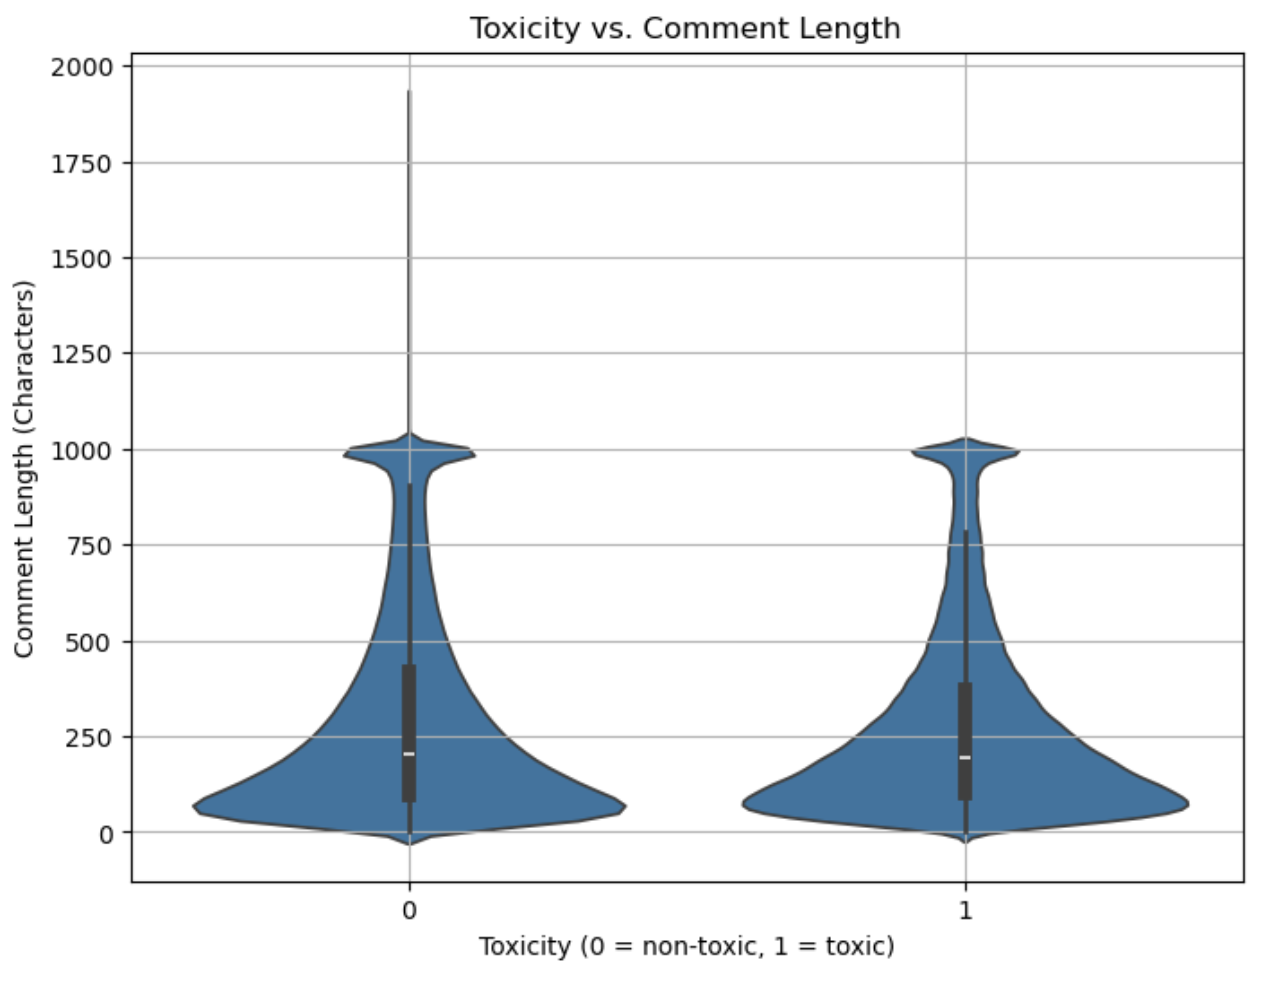

<p align="left"><strong>Figure 1.3: Toxicity vs Comment Length</strong></p>


The violin plot shows that the comment length for both toxic and non-toxic comments are fairly similar ranging. The median comment length in both seems to be around 250 characters. We can see, then, that toxicity does not seem to be very dependent on comment length.

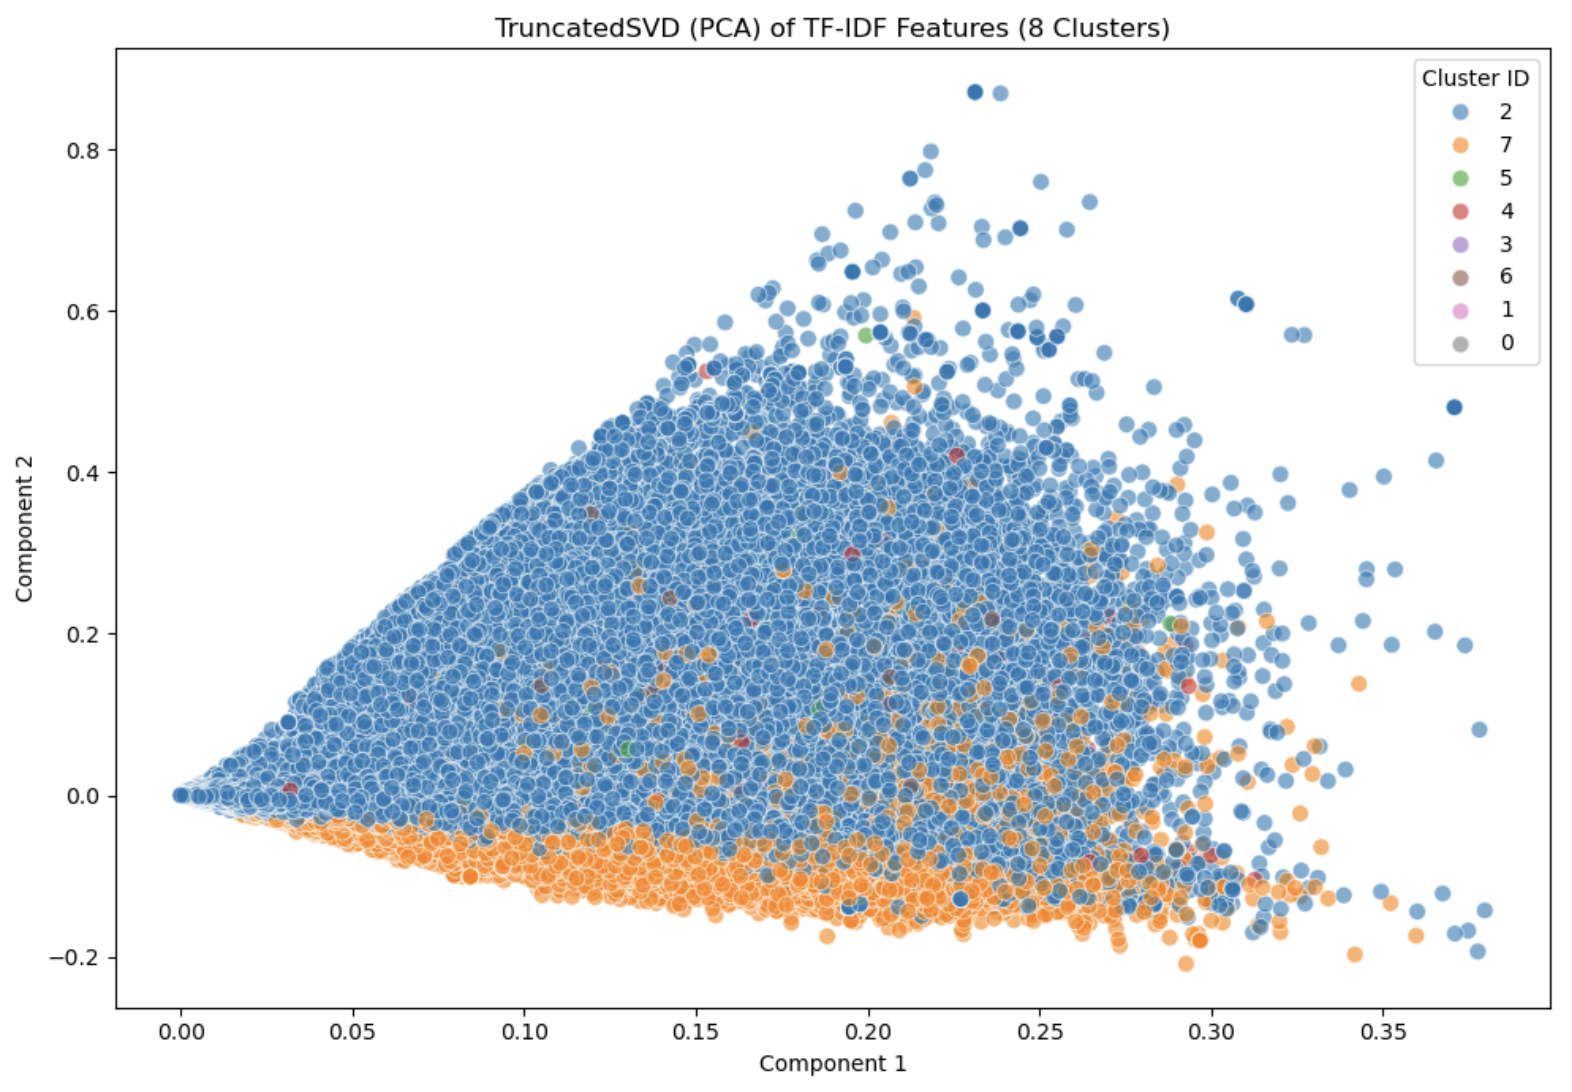

<p align="left"><strong>Figure 1.4: PCA</strong></p>


The above PCA is the result of an idea from chatGPT on how else we could visualize our data.  By separating into our known number of clusters (8 total including the majority non-toxic), we can see that non-toxic dominates, but there's an interesting trend with category 7 as well.  The rest are all scattered, which makes sense, since all of these toxic posts will likely have similar key words or characteristics no matter if they are insulting, obscene, etc.  It would require a lot more semantic work to distill these clusters down to separate issues, especially given their sparsity in the data.

We did a little extra work trying to write out the "top" comments for each cluster in an attempt to make "human" labels manually based on our known categories, but omitted that from this report given the high degree of difficulty in choosing which category was which based on a few readings of comments.  This shows that we have our work cut out for us as we take the next steps towards using BERT and NLP for specific sentiment classification and analysis.

<a id="preprocess1"></a>

## Preprocessing
[Return to contents](#contents)

1.  We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 
2. After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.
3. Feature scaling is not necessary for our classification task—the input is text and the output is binary.
4. We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.
5. We combined the `severe_toxic` and `toxic` class.

### 1. We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 

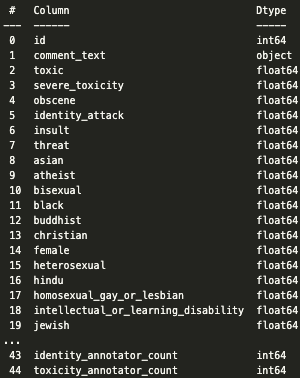

---

### 2. After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.

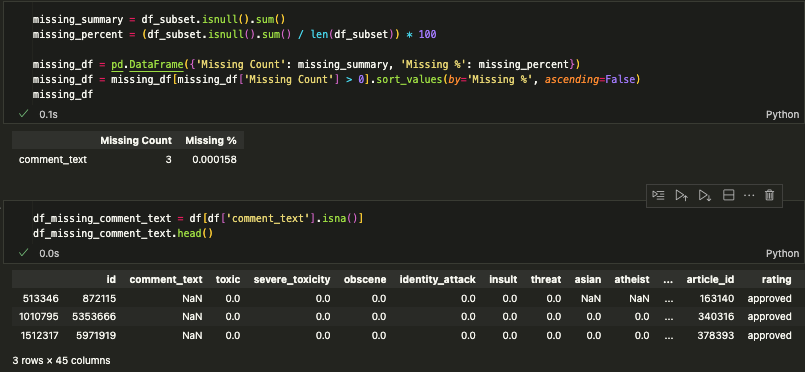

---

### 3. Feature scaling is not necessary for our classification task—the input is text and the output is binary.

---

### 4. We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.

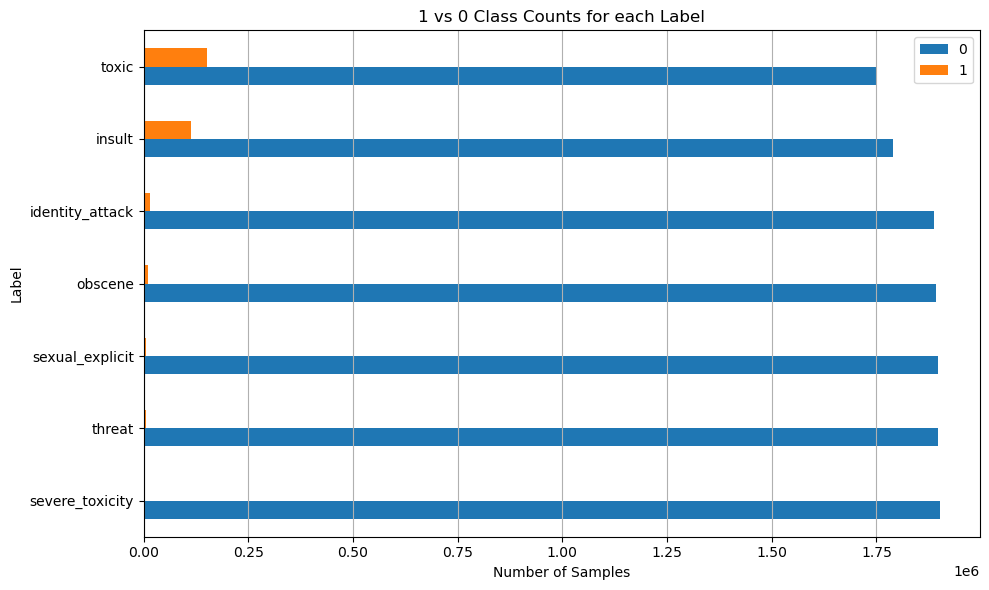

<p align="left"><strong>Figure 1.5: Class Count for Labels</strong></p>

---

In [5]:
# Read the data
df = pd.read_csv("data/cleaned_ms2_data.csv")
df.head(3)

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0


### 5. Combine toxic and severe toxicity

In [6]:
# Combine toxic and severe_toxicity
df['toxic'] = df['toxic'] | df['severe_toxicity']
df = df.drop(columns=['severe_toxicity'])

In [7]:
# Hold out a stratified test set
X = df['comment_text']
y = df['toxic']
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=109,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.10,
    random_state=109,
    stratify=y_temp
)

# Reconstruct train‐frame and re-name label in anticipation of hugging face trainer
train_df = pd.DataFrame({'comment_text': X_train, 'labels': y_train})
test_df = pd.DataFrame({'comment_text': X_test, 'labels': y_test})
val_df = pd.DataFrame({'comment_text': X_val, 'labels': y_val})

---

##### 6: Upsample the `toxic` class in training set 

In [8]:
# Separate toxic and non-toxic comments
train_df = pd.DataFrame({'comment_text': X_train, 
                         'labels': y_train})
tox = train_df[train_df.labels == 1]
nontox = train_df[train_df.labels == 0]

# Upsample the toxic class to match non-toxic size
tox_upsampled = resample(
    tox,
    replace=True,
    n_samples=len(nontox),
    random_state=109
)

train_balanced = pd.concat([nontox, tox_upsampled]).sample(frac=1, random_state=109)
train_balanced.labels.value_counts()

labels
0    1260056
1    1260056
Name: count, dtype: int64

##### The stage is now set for tokenization and to train the model!

<a id="model"></a>

# 3. Modeling
[Return to contents](#contents)

## [MS4 Recap] Baseline Model: DistilBERT

### Baseline Model Choice Reasoning

For our baseline model, we selected DistilBERT, prioritizing a balance of simplicity, interpretability, and relevance to our task. We previously used DistilBERT in Lab 10 for sentiment analysis — a task structurally similar to our project — which reinforced its applicability to this classification setting.

As a lighter and faster derivative of BERT, DistilBERT retains approximately 95% of BERT’s performance while using only 50% of the parameters, enabling faster training and inference. This efficiency allows us to rapidly evaluate model viability on our dataset without prematurely committing extensive computational resources. Moreover, because DistilBERT preserves core BERT design principles — such as bidirectional encoding, rectangular padded/truncated input representations, and compatibility with limited-sample settings — it provides a proxy for the behaviors of larger transformer models.

Using DistilBERT gives us confidence that strong baseline results will generalize when we transition to more powerful architectures (e.g., DeBERTa or larger LLMs) in the final stages of our project. Our final model plans are discussed in more depth in Section 5.

### Baseline Model Training Process

**1. Model and Tokenizer Initialization**
We initialized the pretrained DistilBERT model and its corresponding tokenizer from the HuggingFace transformers library. This ensured compatibility between text preprocessing and model input expectations.

**2. Tokenization of Datasets**
Each of our data splits (training, validation, and test) was tokenized individually using the DistilBERT tokenizer. Inputs were padded and truncated to a uniform maximum sequence length to enable efficient batch processing.

**3. Tensor Dataset Creation**
We converted the tokenized outputs into TensorFlow tensor datasets, aligning token IDs, attention masks, and target labels for supervised learning.

**4. Dataset Optimization: Sampling, Batching, and Buffering**
To accelerate training, we applied sampling, batching, and prefetch buffering techniques:

- Shuffled the training dataset
- Batched into mini-batches of fixed size (32)
- Prefetched buffered batches to improve GPU utilization

Originally, we used only a subsample of the dataset to speed up the training process and gain insights quicker.

**5. Training Configuration**
We allowed the model to train for 5 epochs, using an appropriate learning rate scheduler and early stopping based on validation AUPRC (Area Under the Precision-Recall Curve).
This allowed us to optimize training duration while avoiding overfitting.

**6. Custom Metrics Definition**
We implemented custom evaluation metrics:

- F1 Score to better evaluate the performance when there is a class imbalance in the dataset
- Normalized Entropy$$\frac{H(\text{model})}{H(\text{baseline})},$$ where $H(\text{model})$ is the model’s entropy (i.e., its binary cross-entropy loss) and $H(\text{baseline})$ is the entropy of a naive or random predictor. Due to the original class imbalance, a naive predictor that always guesses “non-toxic” would achieve over 95% accuracy.
- SupRC (smoothed AUPRC) for stability
- A custom binary F1 score function compatible with DistilBERT’s raw logits output

**7. Model Compilation**
We compiled the model with:

- Binary Cross-Entropy loss function
- Adam optimizer with an adaptive learning rate
- These choices aligned with best practices for binary classification tasks using transformer models.

**8. Training Execution**
We executed the training loop, recording the history of loss and evaluation metrics across epochs for further analysis and model selection.


### Model Pipeline

![Description of image](images/Distilbert.jpg)

<p align="left"><strong>Figure 2.1: DistilBERT Pipeline</strong></p>
<p align="left"><em>Chitty-Venkata et. al, 2023<em></p>




## [Baseline Model] DistilBERT Training Log

**Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.**

Epoch 1/5

125/125 [==============================] - 82s 507ms/step - loss: 0.5696 - accuracy: 0.6580 - precision: 0.8355 - recall: 0.3935 - f1_score: 0.7209 - AUPRC: 0.7652 - normalized_entropy: 2.0277 - val_loss: 0.3790 - val_accuracy: 0.8270 - val_precision: 0.9247 - val_recall: 0.7120 - val_f1_score: 0.8435 - val_AUPRC: 0.8853 - val_normalized_entropy: 1.3055 - lr: 1.0000e-05

**Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.**

Epoch 2/5

125/125 [==============================] - 57s 453ms/step - loss: 0.3585 - accuracy: 0.8493 - precision: 0.8782 - recall: 0.8110 - f1_score: 0.8557 - AUPRC: 0.8622 - normalized_entropy: 1.2866 - val_loss: 0.3266 - val_accuracy: 0.8580 - val_precision: 0.9182 - val_recall: 0.7860 - val_f1_score: 0.8604 - val_AUPRC: 0.8793 - val_normalized_entropy: 1.1848 - lr: 1.0000e-05

**Epoch 3: LearningRateScheduler setting learning rate to 7.499999810534064e-06.**

Epoch 3/5

125/125 [==============================] - 57s 454ms/step - loss: 0.2943 - accuracy: 0.8857 - precision: 0.9076 - recall: 0.8590 - f1_score: 0.8879 - AUPRC: 0.8903 - normalized_entropy: 1.0561 - val_loss: 0.3012 - val_accuracy: 0.8760 - val_precision: 0.8933 - val_recall: 0.8540 - val_f1_score: 0.8851 - val_AUPRC: 0.8801 - val_normalized_entropy: 1.1201 - lr: 7.5000e-06

**Epoch 4: LearningRateScheduler setting learning rate to 3.749999905267032e-06.**

Epoch 4/5

125/125 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.8985 - precision: 0.9142 - recall: 0.8795 - f1_score: 0.9068 - AUPRC: 0.9103 - normalized_entropy: 0.9226Restoring model weights from the end of the best epoch: 2.
125/125 [==============================] - 62s 492ms/step - loss: 0.2571 - accuracy: 0.8985 - precision: 0.9142 - recall: 0.8795 - f1_score: 0.9068 - AUPRC: 0.9103 - normalized_entropy: 0.9226 - val_loss: 0.3184 - val_accuracy: 0.8650 - val_precision: 0.9294 - val_recall: 0.7900 - val_f1_score: 0.8665 - val_AUPRC: 0.8859 - val_normalized_entropy: 1.1192 - lr: 3.7500e-06
Epoch 4: early stopping

-----------

## [Baseline Model] Metrics vs. Epochs

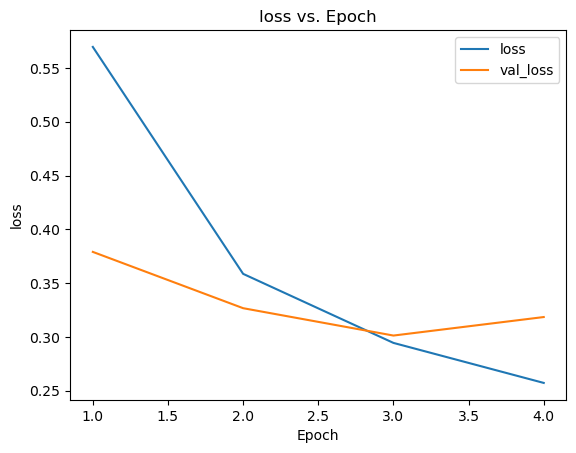

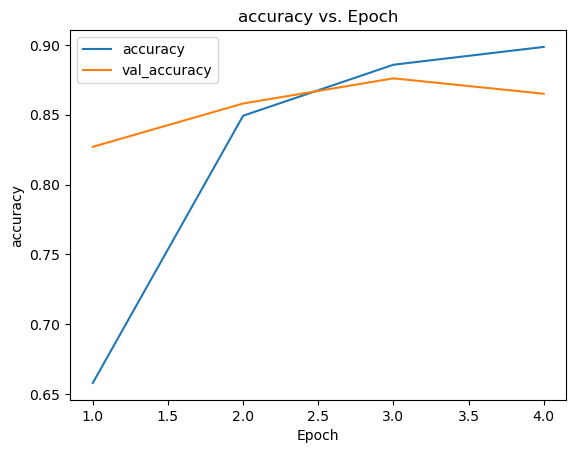

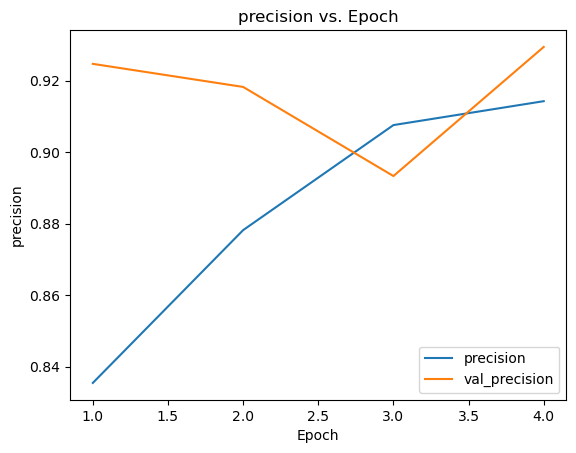

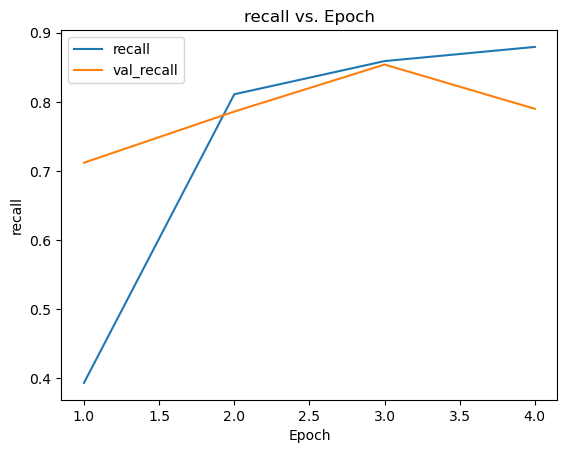

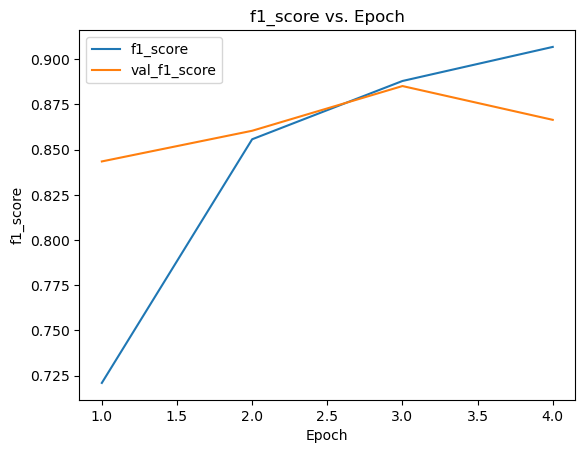

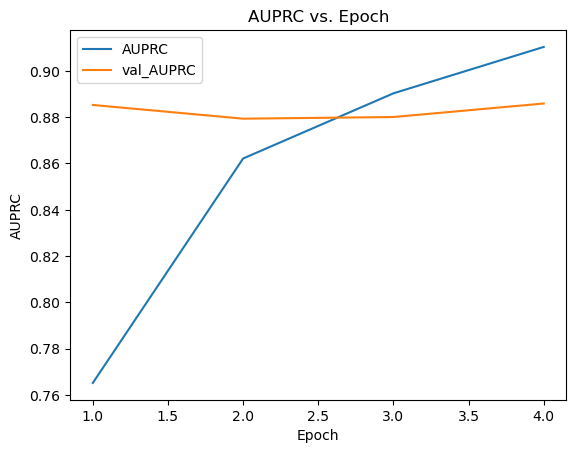

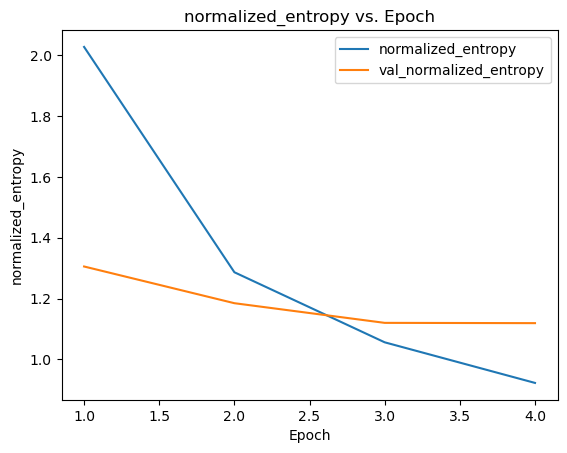

<p align="left"><strong>Figures 2.2-2.8: Baseline Model Performances</strong></p>

------

## [Baseline Model] Evaluating our DistilBERT model against `test_ds`

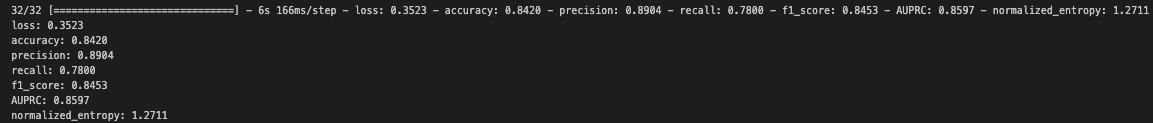

--------

## Final Optimal Model: Electra (Google)
ELECTRA (short for Efficiently Learning an Encoder that Classifies Token Replacements Accurately) is a family of Transformer-based text encoders introduced by Google Brain & Stanford in 2020. Rather than learning by predicting masked‐out words like BERT, ELECTRA learns by detecting which words have been replaced by a small “generator” model. This training game is called Replaced-Token Detection (RTD).

Paper Here: https://openreview.net/pdf?id=r1xMH1BtvB

##### Modeling Choice
We chose this as a baseline model for a few reasons:
- ELECTRA’s replaced-token detection objective gets much more learning signal per token than masked-LM (BERT/Roberta) because the discriminator sees every token instead of just the masked 15 %. In Google’s paper the small model (35 M params) reached BERT-Base quality while using ~4× less compute.
- Overall better performance than base BERT. On most GLUE/SuperGLUE style tasks, a same-sized ELECTRA variant is ≈1–2 points ahead of an equally sized BERT, and an ELECTRA-Small often beats BERT-Base.

### Electra Pipeline

![Description of image](images/Electra.jpg)
<p align="left"><strong>Figure 3.1: Electra Model Pipeline</strong></p>
<p align="left"><em>Clark et al., 2020<em></p>

<a id="train"></a>

## Training Process
[Return to contents](#contents)

**1. Model and Tokenizer Initialization**
We initialized the pretrained Electra model and its corresponding tokenizer from the HuggingFace transformers library. This ensured compatibility between text preprocessing and model input expectations.

**2. Tokenization of Datasets**
Each of our data splits (training, validation, and test) was tokenized individually using the Electra tokenizer. Inputs were padded and truncated to a uniform maximum sequence length to enable efficient batch processing. Employed LoRA and 4Bit quantiation for processing efficiency.

**3. Dataset Creation**
We converted the tokenized outputs into HuggingFace Datasets, aligning token IDs, attention masks, and target labels for supervised learning.

**4. Dataset Optimization: Sampling, Batching, and Buffering**
To accelerate training, we applied sampling, batching, and prefetch buffering techniques:

- Shuffled the training dataset
- Batched into mini-batches of fixed size (32)
- Prefetched buffered batches to improve GPU utilization

**5. Training Configuration**
We trained the model for 8 epochs, using a linear learning rate scheduler and early stopping based on validation AUPRC (Area Under the Precision-Recall Curve).
This allowed us to optimize training duration while avoiding overfitting.

**6. Custom Metrics Definition**
We implemented custom evaluation metrics:

- F1 Score for binary classification
- Normalized Entropy to measure output uncertainty
- SupRC (smoothed AUPRC) for stability
- A custom binary F1 score function compatible with DistilBERT’s raw logits output

**7. Model Compilation**
We compiled the model with:

- Binary Cross-Entropy loss function
- Adam optimizer with an adaptive learning rate
- These choices aligned with best practices for binary classification tasks using transformer models.

**8. Training Execution**
We executed the training loop, recording the history of loss and evaluation metrics across epochs for further analysis and model selection.

**9. Evaluation**
We employed a confusion plot to see our precision and recall metrics, as well as printed comments for each quandrant to see how our model
decided to classify comments.  Based on the outputs, our human judgement shows it is quite fair, as the TP and TF labels make sense.

In [ ]:
# 1) Create huggingface datasets from Dataframes above
small_train = train_balanced.sample(n=20000, random_state=42).reset_index(drop=True)
small_val   = val_df.sample(n=5000, random_state=42).reset_index(drop=True)
small_test  = test_df.sample(n=5000, random_state=42).reset_index(drop=True)

train_ds = Dataset.from_pandas(small_train, preserve_index=False)
val_ds   = Dataset.from_pandas(small_val, preserve_index=False)
test_ds  = Dataset.from_pandas(small_test, preserve_index=False)

In [ ]:
# 2) Set up tokenizer and encode, otherwise load from pre-existing file to save encoding time
# Set model name
model_name = "google/electra-small-discriminator"

# Apply 4-bit Quantization for 209b
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,  # or torch.bfloat16 if your GPU supports it
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config, # incorporates 4bit
    device_map="auto"
)

# Apply LoRA for 209b
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    inference_mode=False,
    target_modules=["query", "key", "value"]  # primary layers to apply LoRA in ELECTRA
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()  # optional debug print

# Initiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define the tokenizer
def tokenize_texts(examples):
    return tokenizer(examples["comment_text"], padding=True, truncation=True, max_length=256)

# Check if encoding already exists, otherwise encode and save to data folder
def encode_or_load(dataset, name):
    path = f"./data/{name}"
    if os.path.exists(path):
        print(f"Loading preprocessed {name} dataset from disk...")
        return load_from_disk(path)
    else:
        print(f"Encoding and saving {name} dataset...")
        encoded = dataset.map(tokenize_texts, batched=True)
        encoded.save_to_disk(path)
        return encoded

# Apply to the train/val/test datasets
encoded_train = encode_or_load(train_ds, "encoded_train")
encoded_val   = encode_or_load(val_ds, "encoded_val")
encoded_test  = encode_or_load(test_ds, "encoded_test")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 213,762 || all params: 13,763,076 || trainable%: 1.5532
Loading preprocessed encoded_train dataset from disk...
Loading preprocessed encoded_val dataset from disk...
Loading preprocessed encoded_test dataset from disk...


In [ ]:
# Print features
encoded_train.features

{'comment_text': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
# 3) Load the electra model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 4) Define our metrics
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
accuracy_metric = evaluate.load("accuracy")
auprc_metric = evaluate.load("roc_auc")  # area under PR curve

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    preds = (probs > 0.5).astype(int)

    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels)["f1"],
        "precision": precision_metric.compute(predictions=preds, references=labels)["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels)["recall"],
        "auprc": auprc_metric.compute(prediction_scores=probs, references=labels)["roc_auc"]
    }

In [ ]:
# 5) Set up hugging face trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="linear", # linear learning rate scheduler input directly into hugging face training args
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="auprc", # monitor auprc
    greater_is_better=True, #higher auprc is better
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train, #currently using small sample for train speed
    eval_dataset=encoded_val, # currently using small sample for train speed
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/tmp/ipykernel_34016/2676006448.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/tmp/ipykernel_34016/2676006448.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 6) Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auprc
1,0.373700,0.327307,0.891200,0.541315,0.414194,0.781022,0.926733
2,0.286300,0.380145,0.838200,0.481742,0.326957,0.914842,0.943282
3,0.291700,0.349485,0.855400,0.507157,0.352273,0.905109,0.946544
4,0.253200,0.419604,0.844600,0.493811,0.337189,0.922141,0.946428
5,0.262900,0.321858,0.886000,0.556765,0.409143,0.871046,0.945860
6,0.300900,0.404809,0.858800,0.511757,0.357488,0.900243,0.946699
7,0.129000,0.444486,0.853600,0.505405,0.349860,0.909976,0.946315
8,0.229500,0.458129,0.851800,0.503018,0.347222,0.912409,0.946412


TrainOutput(global_step=10000, training_loss=0.2945347529232502, metrics={'train_runtime': 699.7453, 'train_samples_per_second': 228.655, 'train_steps_per_second': 14.291, 'total_flos': 2353571266560000.0, 'train_loss': 0.2945347529232502, 'epoch': 8.0})

In [ ]:
# 7) Evaluate on Test Set
results = trainer.evaluate(encoded_test)

print("\n Test Set Evaluation Metrics:")
for metric, value in results.items():
    print(f"{metric:>20}: {value:.4f}")


 Test Set Evaluation Metrics:
           eval_loss: 0.4204
       eval_accuracy: 0.8512
             eval_f1: 0.4761
      eval_precision: 0.3210
         eval_recall: 0.9210
          eval_auprc: 0.9489
        eval_runtime: 7.3332
eval_samples_per_second: 681.8330
eval_steps_per_second: 21.4100
               epoch: 8.0000


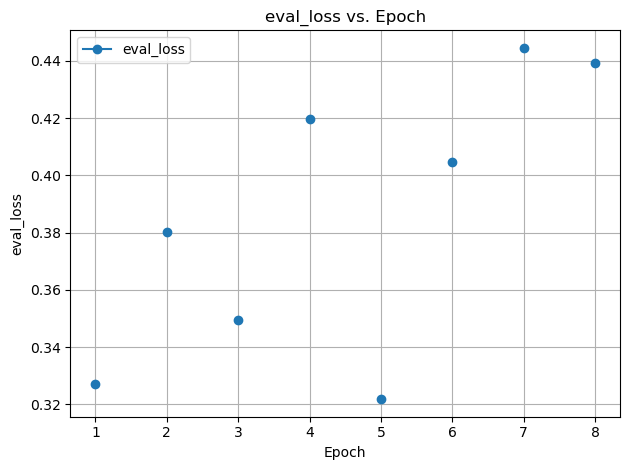

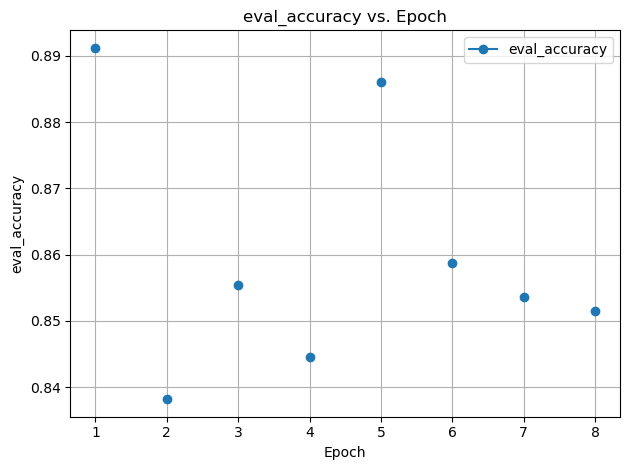

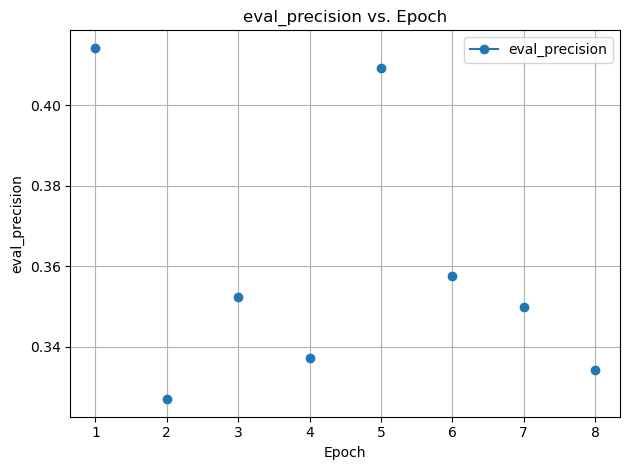

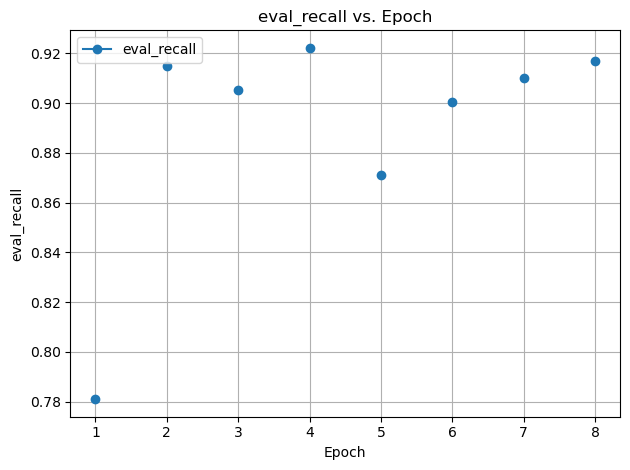

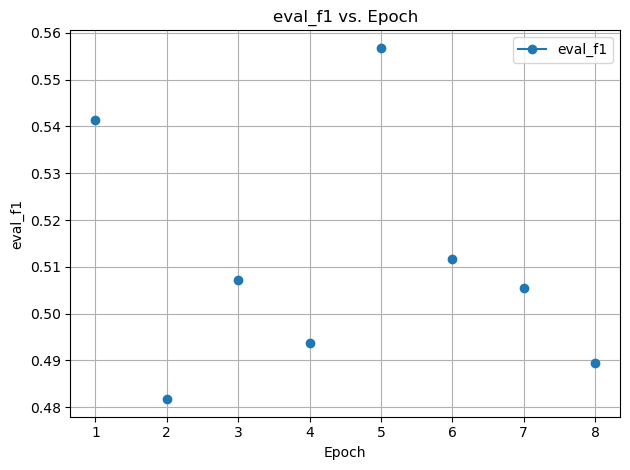

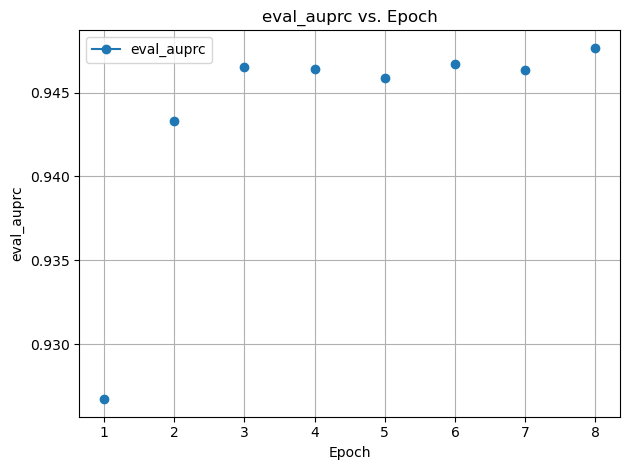

In [ ]:
# 8) Plot the training history
# Convert log history into a DataFrame
log_history = pd.DataFrame(trainer.state.log_history)

# Keep only entries where all fields exist
log_history = log_history[log_history["epoch"].notna() & log_history["step"].notna()]

# Group by epoch to get 1 point per epoch
log_epoch_avg = log_history.groupby("epoch").mean().reset_index()

# Define metrics to plot
metrics = ["eval_loss", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1", "eval_auprc"]

# Plot each metric over epochs
for metric in metrics:
    if metric in log_epoch_avg.columns:
        plt.figure()
        plt.plot(log_epoch_avg["epoch"], log_epoch_avg[metric], marker='o', linestyle='-', label=metric)
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"{metric} vs. Epoch")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

<p align="left"><strong>Figures 3.2–3.7: Metrics over Epochs</strong></p>

## Confusion Matrix ##

Here we evaluate the fairness and reliability of our model in assessing toxicity with a confusion matrix.  We also print out example comments so a human reader can assess why certain comments may be misclassified (and also ascertain which comments are correctly identified as toxic or nontoxic)

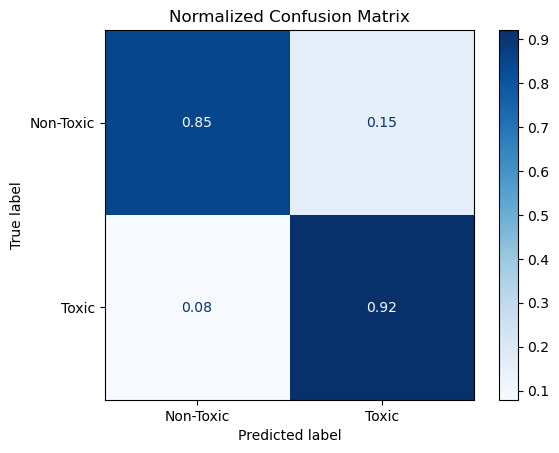

In [ ]:
# Step 1: Get model predictions
predictions = trainer.predict(encoded_test)
logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)

# Step 2: Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')  # row-normalized
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])

# Step 3: Plot
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

<p align="left"><strong>Figure 3.7: Normalized Confusion Matrix</strong></p>

## Comparing Comments between quadrants of the confusion matrix ##

In [ ]:
# Step 1: Get predictions and labels
predictions = trainer.predict(encoded_test)
logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)

# Step 2: Convert to a DataFrame with comment text
test_df_copy = small_test.copy()
test_df_copy["true_label"] = y_true
test_df_copy["predicted_label"] = y_pred
test_df_copy["category"] = ""

# Step 3: Define quadrants
conditions = [
    (test_df_copy["true_label"] == 1) & (test_df_copy["predicted_label"] == 1),  # TP
    (test_df_copy["true_label"] == 0) & (test_df_copy["predicted_label"] == 1),  # FP
    (test_df_copy["true_label"] == 0) & (test_df_copy["predicted_label"] == 0),  # TN
    (test_df_copy["true_label"] == 1) & (test_df_copy["predicted_label"] == 0),  # FN
]
labels = ["TP", "FP", "TN", "FN"]
test_df_copy["category"] = np.select(conditions, labels)

# Step 4: Sample 2 examples per category
examples_by_category = (
    test_df_copy.groupby("category")
    .apply(lambda x: x.sample(n=2, random_state=42) if len(x) >= 2 else x)
    .reset_index(drop=True)
)

# Step 5: Pretty print with wrapped text
for _, row in examples_by_category.iterrows():
    print(f"\nCategory: {row['category']}")
    print(f"True Label: {row['true_label']}, Predicted: {row['predicted_label']}")
    print("Comment:")
    print(textwrap.fill(row["comment_text"], width=100))
    print("-" * 100)


Category: FN
True Label: 1, Predicted: 0
Comment:
Yes, but when that was written there was not a red leftist media and minority of crazies in the
country called progressives!
----------------------------------------------------------------------------------------------------

Category: FN
True Label: 1, Predicted: 0
Comment:
Why is that there are always some people who feel they need to bring their favorite turd-casserole
to the community potluck?
----------------------------------------------------------------------------------------------------

Category: FP
True Label: 0, Predicted: 1
Comment:
but it a basic statement of  fact proscenium - hardly an ad hominem  THD's argument would be far
more convincing if it came from a converted skeptic and not a true believer with a potentially self
serving agenda
----------------------------------------------------------------------------------------------------

Category: FP
True Label: 0, Predicted: 1
Comment:
OMG-get a life. Seriously. Inan

/tmp/ipykernel_34016/1140360302.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=42) if len(x) >= 2 else x)


## Modeling Take 2: FastText N-gram Model

#### Objective: A faster model with good performance

Although the Electra model yields great performance, the problem is that the model has a non-trivial amount of parameters and takes time to train and run inference with. In a production setting where we may need to classify millions of user comments, the speed of the model is really important. In some cases, we may be even willing to trade performance for speed: for example, run a light-weight model for the first filtering, and only run a more accurate but more heavy-weight model on comments that the first model isn't very sure of.

The FastText N-gram model is a great candidate for a simple, lightweight model that runs fast. It breaks down words into ngrams, and assign each ngram an embedding. Then, we run a simple MLP layer on top of the concatenated embeddings of a sentence. FastText is a library developed by Meta ([Link](https://fasttext.cc/)). Although we won't use their library, the model's design is inspired by fast text.


Although its performance is not as good as transformers, it is still widely used in the industry. For example, in LLM pre-training, Many people choose to use FastText / N-gram models to quickly filter out low-quality per-training text. Due to the high volume of pre-training text, sometimes running a large Transformer-based NLP classifier to filter out text isn't feasible. Hence, a N-gram model is often used. For example, Llama 3.1's pre-training team uses Fast Text ([Link](https://www.linkedin.com/posts/ehsan-jahangiri-78b1645b_llm-fasttext-pretraining-activity-7235857803435724800-1V-O/)).

In this experiment, we will run our training data on the fast text classifier and evaluate its performance.

**Model Architecture & Training Process**: We developed a custom N-gram model, where we first do a pooling of all the n-gram embeddings (for more details see below), and we use a simple MLP layer to process the pooled embeddings. We then used a cross-entropy loss to train the model. We used an Adam optimizer with lr = 1e-3.

Several advanced techniques we used:

1. We used **multi-gram (multiple n-grams)**: we split up the sentence into words, and consider 1-gram, 2-grams and 3-grams. 1-gram captures word embedding itself, whereas 2-grams and 3-grams represent more high-level semantic meanings.
2. We used **TF-IDF-weighted EmbeddingBag**: the original FastText classifier uses the average of word embeddings as a representation of the text. However, different words appear at different frequencies and are of different importance. TF-IDF ([Link] https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a common technique in NLP to assign weights to words based on how common they are in the text / entire documnet. Using TF-IDF weights instead of simple average could improve performance of our N-gram model.


### Modeling Pipeline
![Description of image](images/FastText.png)
<p align="left"><strong>Figure 3.1: Electra Model Pipeline</strong></p>
<p align="left"><em>Hand-drawn by Isaac</em></p>

In [ ]:
# Total number of hash buckets for n-gram feature hashing
NUM_BUCKETS = 2**18

def ngram_hash_list(text: str, ngram_range=(1,3), num_buckets=NUM_BUCKETS):
    """
    Convert `text` into a list of hashed n-gram indices.
    Each n-gram is MD5-hashed into one of `num_buckets` buckets.
    """
    # Lowercase and split on whitespace to get tokens
    toks = text.lower().split()
    idxs = []

    # Loop over each n in the requested n-gram range
    for n in range(ngram_range[0], ngram_range[1] + 1):
        # Slide a window of length n across the token list
        for i in range(len(toks) - n + 1):
            ng = " ".join(toks[i : i + n])  # build the n-gram string

            # Hash the n-gram string to an integer in [0, num_buckets)
            h = int(hashlib.md5(ng.encode()).hexdigest(), 16) % num_buckets
            idxs.append(h)

    # If no n-grams (empty text), return a default bucket [0]
    return idxs or [0]


def add_fasttext_ids(examples):
    """
    Given a batch dict with key "comment_text",
    compute and add "ngram_ids" by hashing each comment.
    """
    examples["ngram_ids"] = [ngram_hash_list(t) for t in examples["comment_text"]]
    return examples


def compute_idf(dataset):
    """
    Compute the IDF (inverse document frequency) vector over all hash buckets.
    Returns a tensor of length NUM_BUCKETS with log-IDF values.
    """
    # Document frequency counter per bucket
    df = torch.zeros(NUM_BUCKETS, dtype=torch.int32)

    # For each document, increment df for unique buckets present
    for ids in dataset["ngram_ids"]:
        df[list(set(ids))] += 1

    N = len(dataset)  # total number of documents

    # Smooth IDF formula: log((N+1)/(df+1)) + 1
    idf = torch.log((N + 1) / (df + 1).float()) + 1

    # Assign zero weight to buckets never seen in training
    idf[df == 0] = 0
    return idf


# Model without TF-IDF weighting: simple FastText-style classifier
class FastTextClassifierOriginal(nn.Module):
    def __init__(self, vocab_size=NUM_BUCKETS, emb_dim=64, num_labels=2):
        super().__init__()
        # EmbeddingBag with mean pooling over variable-length inputs
        self.emb = nn.EmbeddingBag(vocab_size, emb_dim, mode="mean")
        # Final linear layer mapping to class logits
        self.fc = nn.Linear(emb_dim, num_labels)

    def forward(self, input_ids=None, offsets=None, labels=None):
        # Compute pooled feature vector
        feats = self.emb(input_ids, offsets)
        logits = self.fc(feats)

        # Compute loss if labels are provided
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}
    

# Model WITH TF-IDF weighting: weighted FastText-style classifier
class FastTextClassifier(nn.Module):
    def __init__(self, idf_tensor, vocab_size=NUM_BUCKETS, emb_dim=64, num_labels=2):
        super().__init__()
        # EmbeddingBag with sum pooling; will apply per-sample weights
        self.emb = nn.EmbeddingBag(vocab_size, emb_dim, mode="sum")
        # Final linear layer for classification
        self.fc  = nn.Linear(emb_dim, num_labels)
        # Register the IDF tensor as a non-trainable buffer
        self.register_buffer("idf", idf_tensor)

    def forward(self, input_ids=None, offsets=None, labels=None):
        # Look up IDF weight for each token index
        weights = self.idf[input_ids]
        # Compute weighted sum pooling of embeddings
        feats   = self.emb(input_ids, offsets, per_sample_weights=weights)
        logits  = self.fc(feats)

        # Compute loss if labels are provided
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}


class DataCollatorFastText:
    """
    Collator to prepare batches for EmbeddingBag:
    - Flattens nested ngram_id lists
    - Computes offsets for each example
    """
    def __call__(self, batch):
        # Collect labels into a tensor
        labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)

        # Compute length (number of n-grams) for each example
        lengths = [len(b["ngram_ids"]) for b in batch]

        # Compute offsets: cumulative sum of previous lengths, starting at 0
        offsets = torch.tensor([0] + list(torch.cumsum(torch.tensor(lengths[:-1]), 0)),
                               dtype=torch.long)

        # Flatten all n-gram IDs into one long tensor
        flat_ids = torch.tensor(sum([b["ngram_ids"] for b in batch], []), dtype=torch.long)

        return {"input_ids": flat_ids, "offsets": offsets, "labels": labels}

In [ ]:
# Resample 20000 rows and do n-gram processing
df = pd.read_csv("data/cleaned_ms2_data.csv")
X = df['comment_text']
y = df['toxic']
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=109,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.10,
    random_state=109,
    stratify=y_temp
)

# Reconstruct train‐frame and re-name label in anticipation of hugging face trainer
train_df = pd.DataFrame({'comment_text': X_train, 'labels': y_train})
test_df = pd.DataFrame({'comment_text': X_test, 'labels': y_test})
val_df = pd.DataFrame({'comment_text': X_val, 'labels': y_val})

train_df.labels.value_counts()

small_train = train_df.sample(n=20000)
small_val = val_df.sample(n=20000)
small_test = test_df.sample(n=20000)

In [ ]:
# Hash each comment’s text into a list of n-gram bucket IDs
small_train["ngram_ids"] = small_train["comment_text"].apply(ngram_hash_list)
small_val["ngram_ids"]   = small_val["comment_text"].apply(ngram_hash_list)
small_test["ngram_ids"]  = small_test["comment_text"].apply(ngram_hash_list)

# Convert each pandas DataFrame into a HuggingFace Dataset
train_dataset = Dataset.from_pandas(small_train)
val_dataset   = Dataset.from_pandas(small_val)
test_dataset  = Dataset.from_pandas(small_test)

# Compute the IDF tensor over the training set’s hashed buckets
idf_tensor = compute_idf(train_dataset)

# Prepare the data collator for EmbeddingBag (flattens ngram_ids + builds offsets)
collator     = DataCollatorFastText()
# Create PyTorch DataLoaders for train/val/test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  collate_fn=collator)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False, collate_fn=collator)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False, collate_fn=collator)

# Set device to GPU if available, else CPU
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the weighted FastText classifier and move it to device
model    = FastTextClassifier(idf_tensor).to(device)
# Use Adam optimizer with a fixed learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-3)

NUM_EPOCHS = 5

# Training & evaluation loop
for epoch in range(NUM_EPOCHS):
    model.train()                     # switch to training mode
    running_loss = 0.0

    # --- Training pass ---
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        offsets   = batch["offsets"].to(device)
        labels    = batch["labels"].to(device)

        optimizer.zero_grad()              # reset gradients
        outputs = model(input_ids, offsets, labels)
        loss    = outputs["loss"]
        loss.backward()                    # backpropagate
        optimizer.step()                   # update weights

        # accumulate total loss (for reporting)
        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # --- Validation pass ---
    model.eval()                       # switch to evaluation mode
    val_loss = 0.0
    correct  = 0
    total    = 0

    with torch.no_grad():             # disable gradient computation
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            offsets   = batch["offsets"].to(device)
            labels    = batch["labels"].to(device)

            outputs = model(input_ids, offsets, labels)
            loss    = outputs["loss"]
            logits  = outputs["logits"]

            val_loss += loss.item() * labels.size(0)

            # compute accuracy
            preds   = torch.argmax(logits, dim=-1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    val_loss /= total
    val_acc   = correct / total

    # Print epoch metrics
    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}]  "
        f"Train Loss: {train_loss:.4f}  "
        f"Val Loss:   {val_loss:.4f}  "
        f"Val Acc:    {val_acc:.4f}"
    )

Epoch [1/5]  Train Loss: 7.0924  Val Loss: 0.6872  Val Acc:  0.7701
Epoch [2/5]  Train Loss: 0.4569  Val Loss: 0.4784  Val Acc:  0.8517
Epoch [3/5]  Train Loss: 0.3897  Val Loss: 0.4858  Val Acc:  0.8629
Epoch [4/5]  Train Loss: 0.3633  Val Loss: 0.4953  Val Acc:  0.8732
Epoch [5/5]  Train Loss: 0.3383  Val Loss: 0.4684  Val Acc:  0.8723


In [ ]:
# Evaluate on Test Set
model.eval()
test_loss = 0.0
correct   = 0
total     = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        offsets   = batch["offsets"].to(device)
        labels    = batch["labels"].to(device)

        outputs = model(input_ids, offsets, labels)
        loss    = outputs["loss"]
        logits  = outputs["logits"]

        test_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=-1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

test_loss /= total
test_acc  = correct / total

print(f"Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4493  Test Accuracy: 0.8723


<a id="interp"></a>

# 4. Results Interpretation & Analysis
[Return to contents](#contents)

**Electra Model Training Results**
Each epoch trained for about 1.5min, over 8 epochs. This model takes longer to train than both DistilBERT and FastText and results (best val_accuracy of 0.8912) is slightly higher, although our metric of improving AUPRC leads us to belive our model is overfitting very quickly, since continual training epochs ultimately reduce accuracy, and our test accuracy was 0.8512.  Given more time and a larger GPU, we believe this model could be tuned much better (slower learning rate to start, over more training samples) to achieve a very high accuracy.  But, its relatively similar performance against much faster models (DistilBERT and FastText) show the power of those models.

**FastText Model Training Results**
After training for 1 minute on 20000 samples, validation accuracy already exceeded 0.87. This shows that the model is extremely fast to train and have very good performance, although not as good as the larger transformer model. This demonstrates that the smaller n-gram fasttest model is capable of achieving high accuracy with a small amount of data and fast training time.

**Conclusion**
We have developed 2 models for the classification task: One heavyweight model with potentially higher accuracy but takes more time to train / run inference with, and a simple model with good accuracy but takes less time to train & run inference with and has less upside for large dataset training, additional fine tuning. In production, we could leverage both models in a tiered approach: the smaller FastText model is used to check comments before they go live; The larger Electra modelis used to scan the comments that the smaller model isn't sure about or is run every day to retroactively scan comments.

## Strengths, Limitations and Future work

Overall, our best model achieves a reasonably good performance. To achieve better performance in terms of test dataset accuracy and inference speed, here are some of the improvements we would work on:

- Train on a larger language model
    - Use Parameter-Efficient Fine-Tuning (PEFT) such as LoRA, Mixed-precision training or quantized training. For example, DeepSeek has experimented with 4-bit training with great results.

    - Use Distributed & Parallel Frameworks: for example, PyTorch FSDP for full-graph sharding across GPUs; NVIDIA Megatron if we have a lot of GPUs and we can train a really large LLM with tensor + pipeline parallelism.


- Additional Data Collection
    - Curriculum Learning with hard negatives

    - Start with a broad toxicity corpus, then progressively add “hard negatives” that the model can't identify and focus on specific domains / new trends (e.g., gen alpha meme) that the model isn't well trained on.

- Synthetic Augmentation with LLMs
    - Use GPT-4-turbo to generate additional examples. For example, for each training example, we can rewrite it with different grammar, tones, emoji uses, etc. or swap identity terms - as we learned in class, this could help with fairness

    - Use self-debiasing: ask the LLM to generate and then critique its own examples, so they can out low-quality or policy-violating text.


- Multi-Lingual Support
    - Mine multilingual social-media streams with language-ID filters, then apply existing toxicity heuristics (keyword lists) to seed labels.

    - Use LLM/BERT with multilingual capability (e.g. XLM-R) to translate examples in the dataset
    -  Monitoring on performance across different languages: Create per-language test datasets; track F1 scores

- Develop an inference workflow for production.
    - We want to serve up to millions of requests per second with high latency requirements (e.g., P99 < 30 ms).

    - Fast serving pipelines such as vLLM can do the trick. vLLM uses virtual KV-cache paging and has advanced capabilities such as batching token inference.

    - We could also consider a tiered approach which is a common system design in the industry: a smaller model (e.g. distilled BERT with a few layers, or highly quantized) to check comments before they go live; A larger model (e.g. full precision with all layers) to scan the comments that the smaller model isn't sure about or is run every day to retroactively scan comments.

### Citations

Peller, J. (2021, November). Jigsaw multilingual toxic comment classification [Data set]. Kaggle. https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification


Chitty-Venkata, K. T., Mittal, S., Emani, M., Vishwanath, V., & Somani, A. K. (2023). A survey of techniques for optimizing Transformer inference. *Journal of Systems Architecture,* 144, 102990. https://doi.org/10.1016/j.sysarc.2023.102990 

Clark, K., Luong, M.-T., Le, Q. V., & Manning, C. D. (2020). ELECTRA: Pre-training Text Encoders as Discriminators Rather Than
  Generators. *ArXiv (Cornell University).* https://doi.org/10.48550/arxiv.2003.10555
